# Testing multiple stressor interactions

Testing higher-order interactions in multiple stressor experiments is a problem that hasn't really been solved yet. Searching the literature for multiple stressor experiments mostly throws up 2-stressor experiments, with very little literature addressing more complex interactions.

In our data we have a large amount of chemical combinations (256) for 12 strains of bacteria, giving a vast quantity of data (~15,000 measurements), but low replication for each treatment (4 replicates of each Bacteria/Stressor mixture combination, many more control measurements). In this we have combinations of up to 8 stressors in a mixture, and individually the stressors may have any of a negative, positive or no effect on a given strain's growth.

I like the approach to defnining interactions between stressors that might work in opposing directions described by Piggott ([2015](https://onlinelibrary.wiley.com/doi/10.1002/ece3.1465)). This amounts to "look at what direction your interaction coefficient goes in compared to the effects of the stressors individually, and do an ANOVA to test interaction significance". However, their methods are only really directly applicable to 2-stressor combinations, also I don't think that the definition of additive (literally the quantity that the stressor increases or decreases growth by) is right for our data. 

Multiple papers by Tekin et al. ([2016](https://royalsocietypublishing.org/doi/10.1098/rsif.2016.0332),[2018](https://www.nature.com/articles/s41540-018-0069-9)) have taken a new approach to defining higher order interactions. They calculate all the lower-order effects in a mixture (*i.e.* in a 3-stressor mixture, all of the individual stressor effects and each of the 2-way interactions) and then generate a metric for the higher order interaction by calculating the overall net effect of the 3-way mixture and minusing all of the lower effects. They then rescale the metric in different ways depending on whether the unscaled metric is negative (synergistic) or positive (antagonistic). This is then compared to some cut-off values that seem to be based on breaks in the histogram distribution for the rescaled metrics to define whether the interaction is "significant" or not.

Problems:
 - They don't consider positive stressor effects - so no rescaling methods for these interaction types.
 - Question of whether comparing metric to a cut-off value is statistically sound and justifiable.
 - Not really as generalisable as they claim? Complicated algebraic formulae for higher-order interactions.

Positive:

Tekin looks at % reduction in growth when looking at stressor effects, and "additive" in a sense becomes multiplicative. The growth ($r$) of a bacteria in the presence of chemicals 1 and 2 is:

$ r_{1,2} = r_{control} I_1 I_2 I_{1,2} $;

where $I_1$ and $I_2$ are the reductions in growth in the presence of stressors 1 and 2 respectively, and $I_{1,2}$ is the interaction between the stressors. I like this and think its applicable to our data.

I think ultimately, with inspiration from Tekin's work, I want to basically extend the Piggot framework to higher-order interactions, using a multiplicative approach to define "additive" effects. I don't want to re-invent the wheel if there's already a good way to do define the interactions in our data, and ideally I want something easily defensible without too much explanation. I think we can do this with a basic linear modelling approach...


## Testing interactions with a linear model approach

For each chemical combination there are two types of linear model to test:

 - a) if there is a net effect "deviation from additivity" of the combination.
 
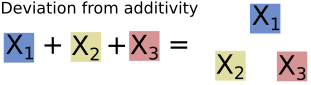

 - b) if the higher order "emergent" interaction (EI) is significant (after accounting for other interactions).

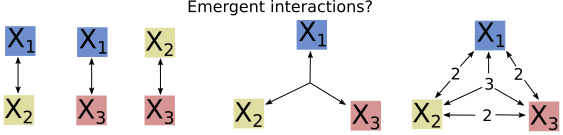

This is similar to Tekin's approach, but I want to do it with linear models. I think we can do this in essentially two ways:

 - Maximal approach: big model of everything, test which parts of the model are significant.
 - Minimal approach: construct more complex models based on what terms we've already found are important in lower-order models.

### Maximal approach

The first approach is easy, take all the data for a given strain and just define a big ol' linear model with all the nested interactions (using the log of the response variable to make the model multiplicative), looks like this in R:

`lm(log(growth) ~ Amoxicillin * Chlorothalonil * Diflufenican * Glyphosate * Imidacloprid * Metaldehyde * Oxytetracycline * Tebuconazole)`

Then need to decide how to figure out what the important terms are. Type-I ANOVA isn't right for this question because the variance is sequentially attributed to each factor in the order of entry into the model, *i.e.* the order in which the terms are specified in the model matters. Type-III would seem more appropriate for our question, only giving each term the variance that is uniquely attributable to it. This is conservative; if you sum all of the sums of squares (SS) from the model terms, it won't equal the total SS - some of the ambiguous SS that could be attributed to multiple terms is discarded. Type-III is what `summary(lm())` in R gives you, so that's it, big model of everything, test which interactions are "significant" - job done. However, this method will probably produce somewhat conservative results.

### Minimal approach

An alternative approach might be to sequentially build more complex models based on the terms which we think are important (*i.e.* forward step-wise regression). We could test all the 2-way interactions, then test all the 3-way interactions, but rather than including every interaction in the 3-way model, include only the 2-way interactions that we've already found to be important in the 2-way models. Continue doing this all the way up to our 8-way model, thereby testing higher-order interactions without "losing" any of the variance to non-significant lower-order terms. 

In retrospect, this is probably not a very good idea. There seems to be quite a body of work saying not to do stepwise regression (e.g. [Smith 2018](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-018-0143-6)). By selecting the "significant" terms as we go, its going to artificially inflate the coefficients and deflate the p-values of the full model, give high $R^2$ by deflating the degrees of freedom, etc. The test statistic and p-values are conditional upon a series of models that include variables not present in the final model.

Arguably the most sensible suggestion for selecting variables to put into a model is to let theory guide which predictors we should put in. That's not helpful here, becuase we're not really trying to build a model to describe chemical effects, we're trying to use models to find out which interactions are important.

### Net effects

Neither of these approaches get at the net effects of "deviation from additivity" of chemical mixtures yet, they're only for looking at emergent interactions. I think we can easily test for the net effects of chemical mixtures by building simple models with all of the single stressor terms, and a term to describe the full combination of chemicals, and ask whether that term is significant. If so, the combined mixture "deviates from additivity".

For 3 stressors $S_{1..3}$ that would look like:

`lm(log(growth) ~ S1 + S2 + S3 + S1:S2:S3)`

We can do this regardless of whether the minimal or maximal approach to emergent interactions is taken.

Below is some example code showing construction of forward step-wise models, but after writing this all out I'm leaning towards the maximal approach of just doing big models of everything, and accepting that it's conservative and we'll probably under-report some interactions.

In [2]:
library(tidyverse)
library(gtools)

setwd("~/Documents/ERCITE/8-chem-exp/")

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



As a method test, trying on a 3-way interaction for just 1 particular strain.

In [3]:
# get data for strain 331
trial_data <- read_csv("results/spline_fits.csv", show_col_types = FALSE) %>%
  arrange(Strain, Complexity) %>%
  filter(Strain == 331)

# filter out the control data
control_data <- trial_data %>%
  filter(Complexity == 0)

Going to look at a 3-way interaction: Amoxicillin - Metaldehyde - Oxytetracycline.

## Test 2 way interactions first

Subsetting the data to only what is relevent to each interaction test and then doing a linear model to test for the interaction.

In [4]:
# A:M
AM_data <- trial_data %>%
  filter(Complexity <= 2,
         (Amoxicillin == 1 | Metaldehyde == 1) & 
           (Chlorothalonil == 0 & Diflufenican == 0 & Glyphosate == 0 & Imidacloprid == 0 & Oxytetracycline == 0 & Tebuconazole == 0)) %>%
  bind_rows(control_data)

AM_mod <- lm(log(AUC) ~ Amoxicillin * Metaldehyde, data = AM_data)
summary(AM_mod) # significant A:M interaction


Call:
lm(formula = log(AUC) ~ Amoxicillin * Metaldehyde, data = AM_data)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.031635 -0.013256  0.000594  0.011974  0.033792 

Coefficients:
                         Estimate Std. Error  t value Pr(>|t|)    
(Intercept)              3.811559   0.001219 3125.539  < 2e-16 ***
Amoxicillin              0.038080   0.008271    4.604 7.61e-06 ***
Metaldehyde              0.032269   0.008271    3.902 0.000133 ***
Amoxicillin:Metaldehyde -0.062790   0.014222   -4.415 1.70e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01636 on 188 degrees of freedom
Multiple R-squared:  0.1614,	Adjusted R-squared:  0.1481 
F-statistic: 12.06 on 3 and 188 DF,  p-value: 2.941e-07


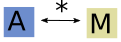

In [5]:
# A:O
AO_data <- trial_data %>%
  filter(Complexity <= 2,
         (Amoxicillin == 1 | Oxytetracycline == 1) & 
           (Chlorothalonil == 0 & Diflufenican == 0 & Glyphosate == 0 & Imidacloprid == 0 & Metaldehyde == 0 & Tebuconazole == 0)) %>%
  bind_rows(control_data)

AO_mod <- lm(log(AUC) ~ Amoxicillin * Oxytetracycline, data = AO_data)
summary(AO_mod) # this time, interaction isn't significant - so don't take it further


Call:
lm(formula = log(AUC) ~ Amoxicillin * Oxytetracycline, data = AO_data)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.031635 -0.013702  0.000505  0.012089  0.033792 

Coefficients:
                             Estimate Std. Error  t value Pr(>|t|)    
(Intercept)                  3.811559   0.001225 3111.630  < 2e-16 ***
Amoxicillin                  0.038080   0.008308    4.584 8.32e-06 ***
Oxytetracycline             -0.083594   0.008308  -10.062  < 2e-16 ***
Amoxicillin:Oxytetracycline -0.022682   0.014285   -1.588    0.114    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01643 on 188 degrees of freedom
Multiple R-squared:  0.5025,	Adjusted R-squared:  0.4945 
F-statistic: 63.29 on 3 and 188 DF,  p-value: < 2.2e-16


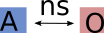

In [6]:
# M:O
MO_data <- trial_data %>%
  filter(Complexity <= 2,
         (Metaldehyde == 1 | Oxytetracycline == 1) & 
           (Chlorothalonil == 0 & Diflufenican == 0 & Glyphosate == 0 & Imidacloprid == 0 & Amoxicillin == 0 & Tebuconazole == 0)) %>%
  bind_rows(control_data)

MO_mod <- lm(log(AUC) ~ Metaldehyde * Oxytetracycline, data = MO_data)
summary(MO_mod) # also no M:O interaction


Call:
lm(formula = log(AUC) ~ Metaldehyde * Oxytetracycline, data = MO_data)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.031635 -0.013612  0.000594  0.012089  0.033792 

Coefficients:
                             Estimate Std. Error  t value Pr(>|t|)    
(Intercept)                  3.811559   0.001224 3114.882  < 2e-16 ***
Metaldehyde                  0.032269   0.008299    3.888  0.00014 ***
Oxytetracycline             -0.083594   0.008299  -10.072  < 2e-16 ***
Metaldehyde:Oxytetracycline -0.015116   0.014270   -1.059  0.29085    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01642 on 188 degrees of freedom
Multiple R-squared:  0.4897,	Adjusted R-squared:  0.4815 
F-statistic: 60.13 on 3 and 188 DF,  p-value: < 2.2e-16


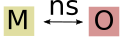

## 3-way interactions

Now test the 3-way interaction, first, what is the net effect of putting these 3 chemicals together? i.e. is there a "deviation from additivity" as used in the Tekin papers.

In [7]:
# step 1, deviation from additivity
AMO_data <- trial_data %>%
  filter(Complexity <= 3,
         (Amoxicillin == 1 | Metaldehyde == 1 | Oxytetracycline == 1) & 
           (Chlorothalonil == 0 & Diflufenican == 0 & Glyphosate == 0 & Imidacloprid == 0 & Tebuconazole == 0)) %>%
  bind_rows(control_data)

AMO_DA <- lm(log(AUC) ~ Amoxicillin + Metaldehyde + Oxytetracycline + Amoxicillin:Metaldehyde:Oxytetracycline, 
             data = AMO_data)
summary(AMO_DA) 


Call:
lm(formula = log(AUC) ~ Amoxicillin + Metaldehyde + Oxytetracycline + 
    Amoxicillin:Metaldehyde:Oxytetracycline, data = AMO_data)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.033192 -0.013682  0.000265  0.012559  0.033351 

Coefficients:
                                         Estimate Std. Error  t value Pr(>|t|)
(Intercept)                              3.812001   0.001242 3068.038  < 2e-16
Amoxicillin                              0.015197   0.005359    2.836  0.00503
Metaldehyde                              0.013169   0.005359    2.458  0.01483
Oxytetracycline                         -0.082640   0.005359  -15.422  < 2e-16
Amoxicillin:Metaldehyde:Oxytetracycline  0.020355   0.010659    1.910  0.05760
                                           
(Intercept)                             ***
Amoxicillin                             ** 
Metaldehyde                             *  
Oxytetracycline                         ***
Amoxicillin:Metaldehyde:Oxytetracycli

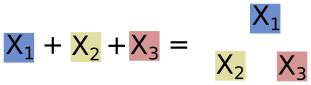

Overall we find no deviation from additivity - this 3-chemical mixture behaves additively. That's interesting, because we found a 2-way interaction earlier between Amoxicillin and Metaldehyde that gets lost when we put Oxytetracycline in too.

Could there could be an emergent 3 way interaction thats opposing the 2-way interaction from earlier causing this return to "additivity"?

Construct a model to test for the 3-way interaction, accounting for the 2-way interactions we already found.

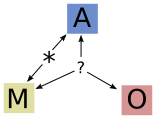

In [8]:
AMO_EI <- lm(log(AUC) ~ Amoxicillin + Metaldehyde + Oxytetracycline + Amoxicillin:Metaldehyde + 
               Amoxicillin:Metaldehyde:Oxytetracycline, 
             data = AMO_data)
summary(AMO_EI)


Call:
lm(formula = log(AUC) ~ Amoxicillin + Metaldehyde + Oxytetracycline + 
    Amoxicillin:Metaldehyde + Amoxicillin:Metaldehyde:Oxytetracycline, 
    data = AMO_data)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.031842 -0.012210  0.000482  0.011673  0.033584 

Coefficients:
                                         Estimate Std. Error  t value Pr(>|t|)
(Intercept)                              3.811767   0.001197 3185.608  < 2e-16
Amoxicillin                              0.031308   0.006444    4.859 2.37e-06
Metaldehyde                              0.029280   0.006444    4.544 9.49e-06
Oxytetracycline                         -0.093147   0.005738  -16.232  < 2e-16
Amoxicillin:Metaldehyde                 -0.053237   0.012776   -4.167 4.57e-05
Amoxicillin:Metaldehyde:Oxytetracycline  0.052110   0.012776    4.079 6.51e-05
                                           
(Intercept)                             ***
Amoxicillin                             ***
Metaldehyde    

There we have it - emergent 3-way interaction opposing the 2-way A:M interaction, making the 3-way mixture appear to behave additively.

Do we re-capture this result with a standard approach to modelling everything?

In [10]:
full.mod <- lm(log(AUC) ~ Amoxicillin * Metaldehyde * Oxytetracycline, data = AMO_data)
summary(full.mod)

anova(full.mod, AMO_EI)


Call:
lm(formula = log(AUC) ~ Amoxicillin * Metaldehyde * Oxytetracycline, 
    data = AMO_data)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.031635 -0.012931  0.000594  0.011461  0.033792 

Coefficients:
                                         Estimate Std. Error  t value Pr(>|t|)
(Intercept)                              3.811559   0.001200 3175.283  < 2e-16
Amoxicillin                              0.038080   0.008141    4.677 5.34e-06
Metaldehyde                              0.032269   0.008141    3.964 0.000103
Oxytetracycline                         -0.083594   0.008141  -10.268  < 2e-16
Amoxicillin:Metaldehyde                 -0.062790   0.013999   -4.485 1.23e-05
Amoxicillin:Oxytetracycline             -0.022682   0.013999   -1.620 0.106744
Metaldehyde:Oxytetracycline             -0.015116   0.013999   -1.080 0.281539
Amoxicillin:Metaldehyde:Oxytetracycline  0.080355   0.021338    3.766 0.000218
                                           
(Intercept)       

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,200,0.05187321,NA,NA,NA,NA
2,202,0.05263695,-2,-0.0007637386,1.472318,0.2318686


Well, we get the same variables as "significant". F-test to compare the models says that the small model without the non-significant variables isn't worse than the big model.

Can do ANOVA to test which variables are important.
Type-1 ANOVA isn't appropriate for the question we're astking because the order of variabes matters:

In [11]:
full.mod.2 <- lm(log(AUC) ~ Metaldehyde * Oxytetracycline * Amoxicillin, data = AMO_data)
anova(full.mod)
anova(full.mod.2)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Amoxicillin,1,0.0019719746,0.0019719746,7.603056,6.366500e-03
Metaldehyde,1,0.0010120700,0.0010120700,3.902091,4.960148e-02
Oxytetracycline,1,0.0672659716,0.0672659716,259.347628,5.783902e-38
Amoxicillin:Metaldehyde,1,0.0012163179,0.0012163179,4.689580,3.152960e-02
Amoxicillin:Oxytetracycline,1,0.0005404241,0.0005404241,2.083635,1.504498e-01
Metaldehyde:Oxytetracycline,1,0.0008805640,0.0008805640,3.395063,6.687216e-02
Amoxicillin:Metaldehyde:Oxytetracycline,1,0.0036779562,0.0036779562,14.180561,2.183267e-04
Residuals,200,0.0518732114,0.0002593661,NA,NA


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Metaldehyde,1,0.0023646809,0.0023646809,9.117156,2.862222e-03
Oxytetracycline,1,0.0645345237,0.0645345237,248.816381,5.934651e-37
Amoxicillin,1,0.0033508116,0.0033508116,12.919237,4.095708e-04
Metaldehyde:Oxytetracycline,1,0.0006601022,0.0006601022,2.545060,1.122186e-01
Metaldehyde:Amoxicillin,1,0.0016481228,0.0016481228,6.354427,1.248971e-02
Oxytetracycline:Amoxicillin,1,0.0003290811,0.0003290811,1.268790,2.613435e-01
Metaldehyde:Oxytetracycline:Amoxicillin,1,0.0036779562,0.0036779562,14.180561,2.183267e-04
Residuals,200,0.0518732114,0.0002593661,NA,NA


Type-3 ANOVA seems the most appropriate approach, accounting for unbalanced designs, albeit rather conservatively. Type-3 ANOVA is implemented in the `car` package.

In [12]:
library(car)
Anova(full.mod, type = 3)

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:gtools’:

    logit


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some




,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),2.615037e+03,1,1.008242e+07,0.000000e+00
Amoxicillin,5.674344e-03,1,2.187774e+01,5.342391e-06
Metaldehyde,4.074690e-03,1,1.571019e+01,1.027135e-04
Oxytetracycline,2.734408e-02,1,1.054266e+02,3.892137e-20
Amoxicillin:Metaldehyde,5.218188e-03,1,2.011901e+01,1.225773e-05
Amoxicillin:Oxytetracycline,6.809290e-04,1,2.625359e+00,1.067443e-01
Metaldehyde:Oxytetracycline,3.024038e-04,1,1.165934e+00,2.815387e-01
Amoxicillin:Metaldehyde:Oxytetracycline,3.677956e-03,1,1.418056e+01,2.183267e-04
Residuals,5.187321e-02,200,NA,NA


Ultimately in this 3-way example, both approaches return the same interactions as being important terms to understand changes in the growth rates - each of the three chemicals, the A:M and the A:M:O interactions.

Note that the Type 3 test is the same as implemented in R's `summary` function, only there the t-values are reported rather than F (but the p-values are the same - look above).